# In application_to_obs.ipynb, we show the main application of the method to observations. This notebook shows checking hypotheses and assumptions made in the method

## First we need to cluster the IAP data again so we have the locations of the IAP mixtures

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

Load in observational temperature and salinity data from the Cheng et al. 2020 paper. The data can be downloaded from http://www.ocean.iap.ac.cn/pages/dataService/dataService.html

In [2]:
#Load in temperature data and then take annual mean
mean_annual_temp=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_temp=np.empty([12,180,360])
    surface_temp[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        temp=xr.open_dataset(f)['temp']
        temp=temp.where(temp<999)
        surface_temp[i-1,:,:]=temp[:,:,0]
    surface_temp=xr.DataArray(surface_temp,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_temp=surface_temp.mean('month')
    mean_annual_temp[j-1973,:,:]=surface_temp
mean_annual_temp=xr.DataArray(mean_annual_temp,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

In [3]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

Regrid the data

In [4]:
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(mean_annual_sal, ds_out, "bilinear",periodic=True)
regrid_iap = regridder(mean_annual_sal)
regrid_iap=regrid_iap.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap=regrid_iap.assign_coords(latitude=regrid_iap.lat[:,0],longitude=regrid_iap.lon[0,:])

regrid_iap_temp=regridder(mean_annual_temp)
regrid_iap_temp=regrid_iap_temp.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap_temp=regrid_iap_temp.assign_coords(latitude=regrid_iap_temp.lat[:,0],longitude=regrid_iap_temp.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [5]:
#Create area grid

import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')

from area_grid import *

area=area_grid(latitudes=np.array(regrid_iap.latitude),longitudes=regrid_iap.longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[regrid_iap.latitude,regrid_iap.longitude])

In [6]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

1e+00
(100000, 6)


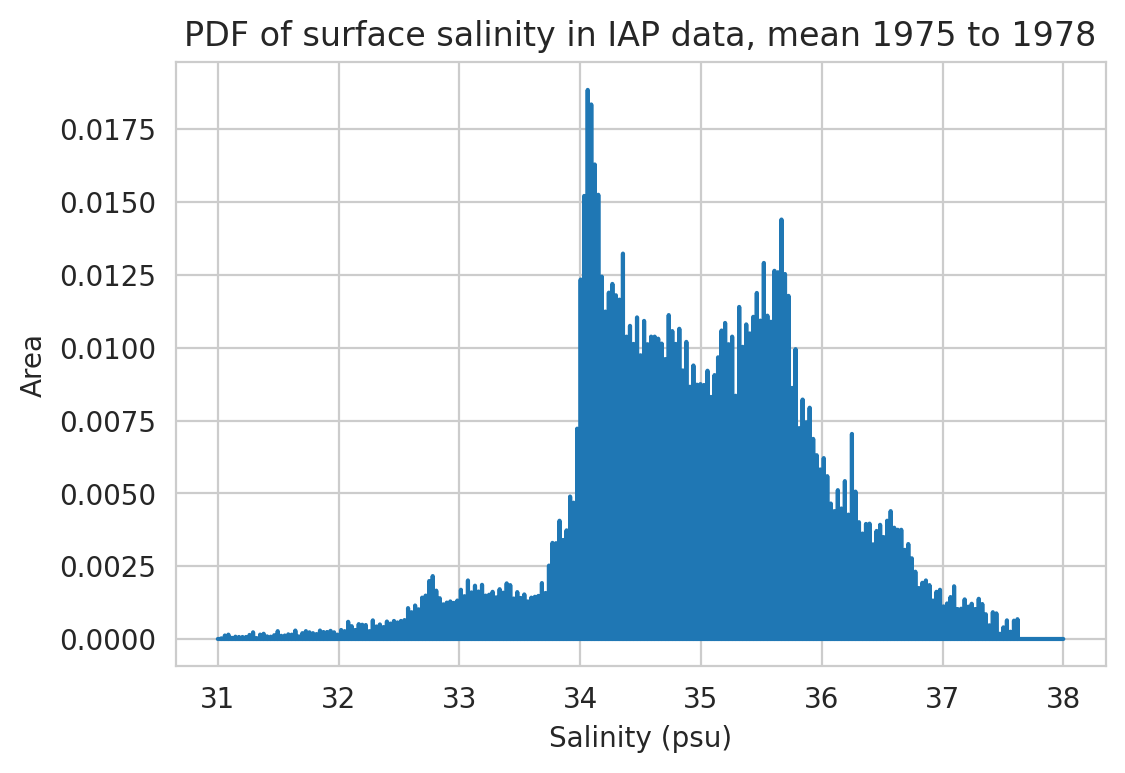

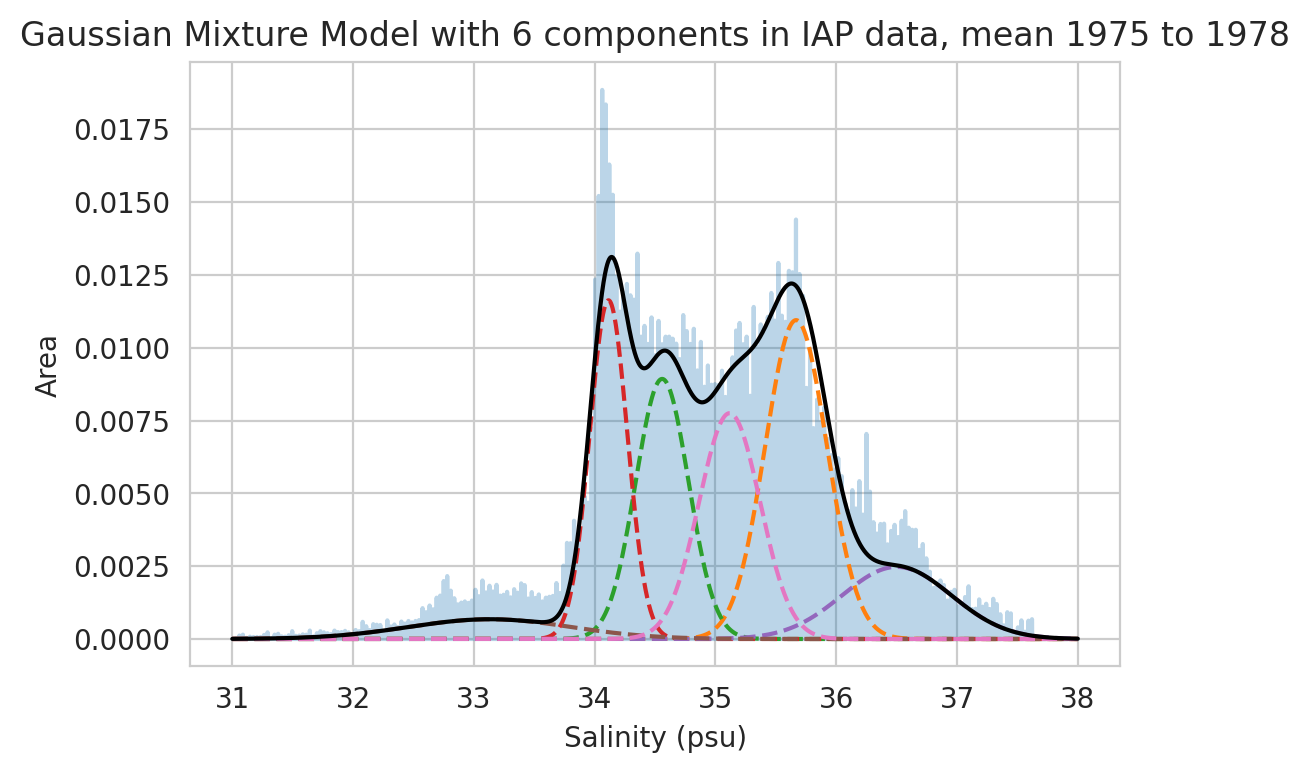

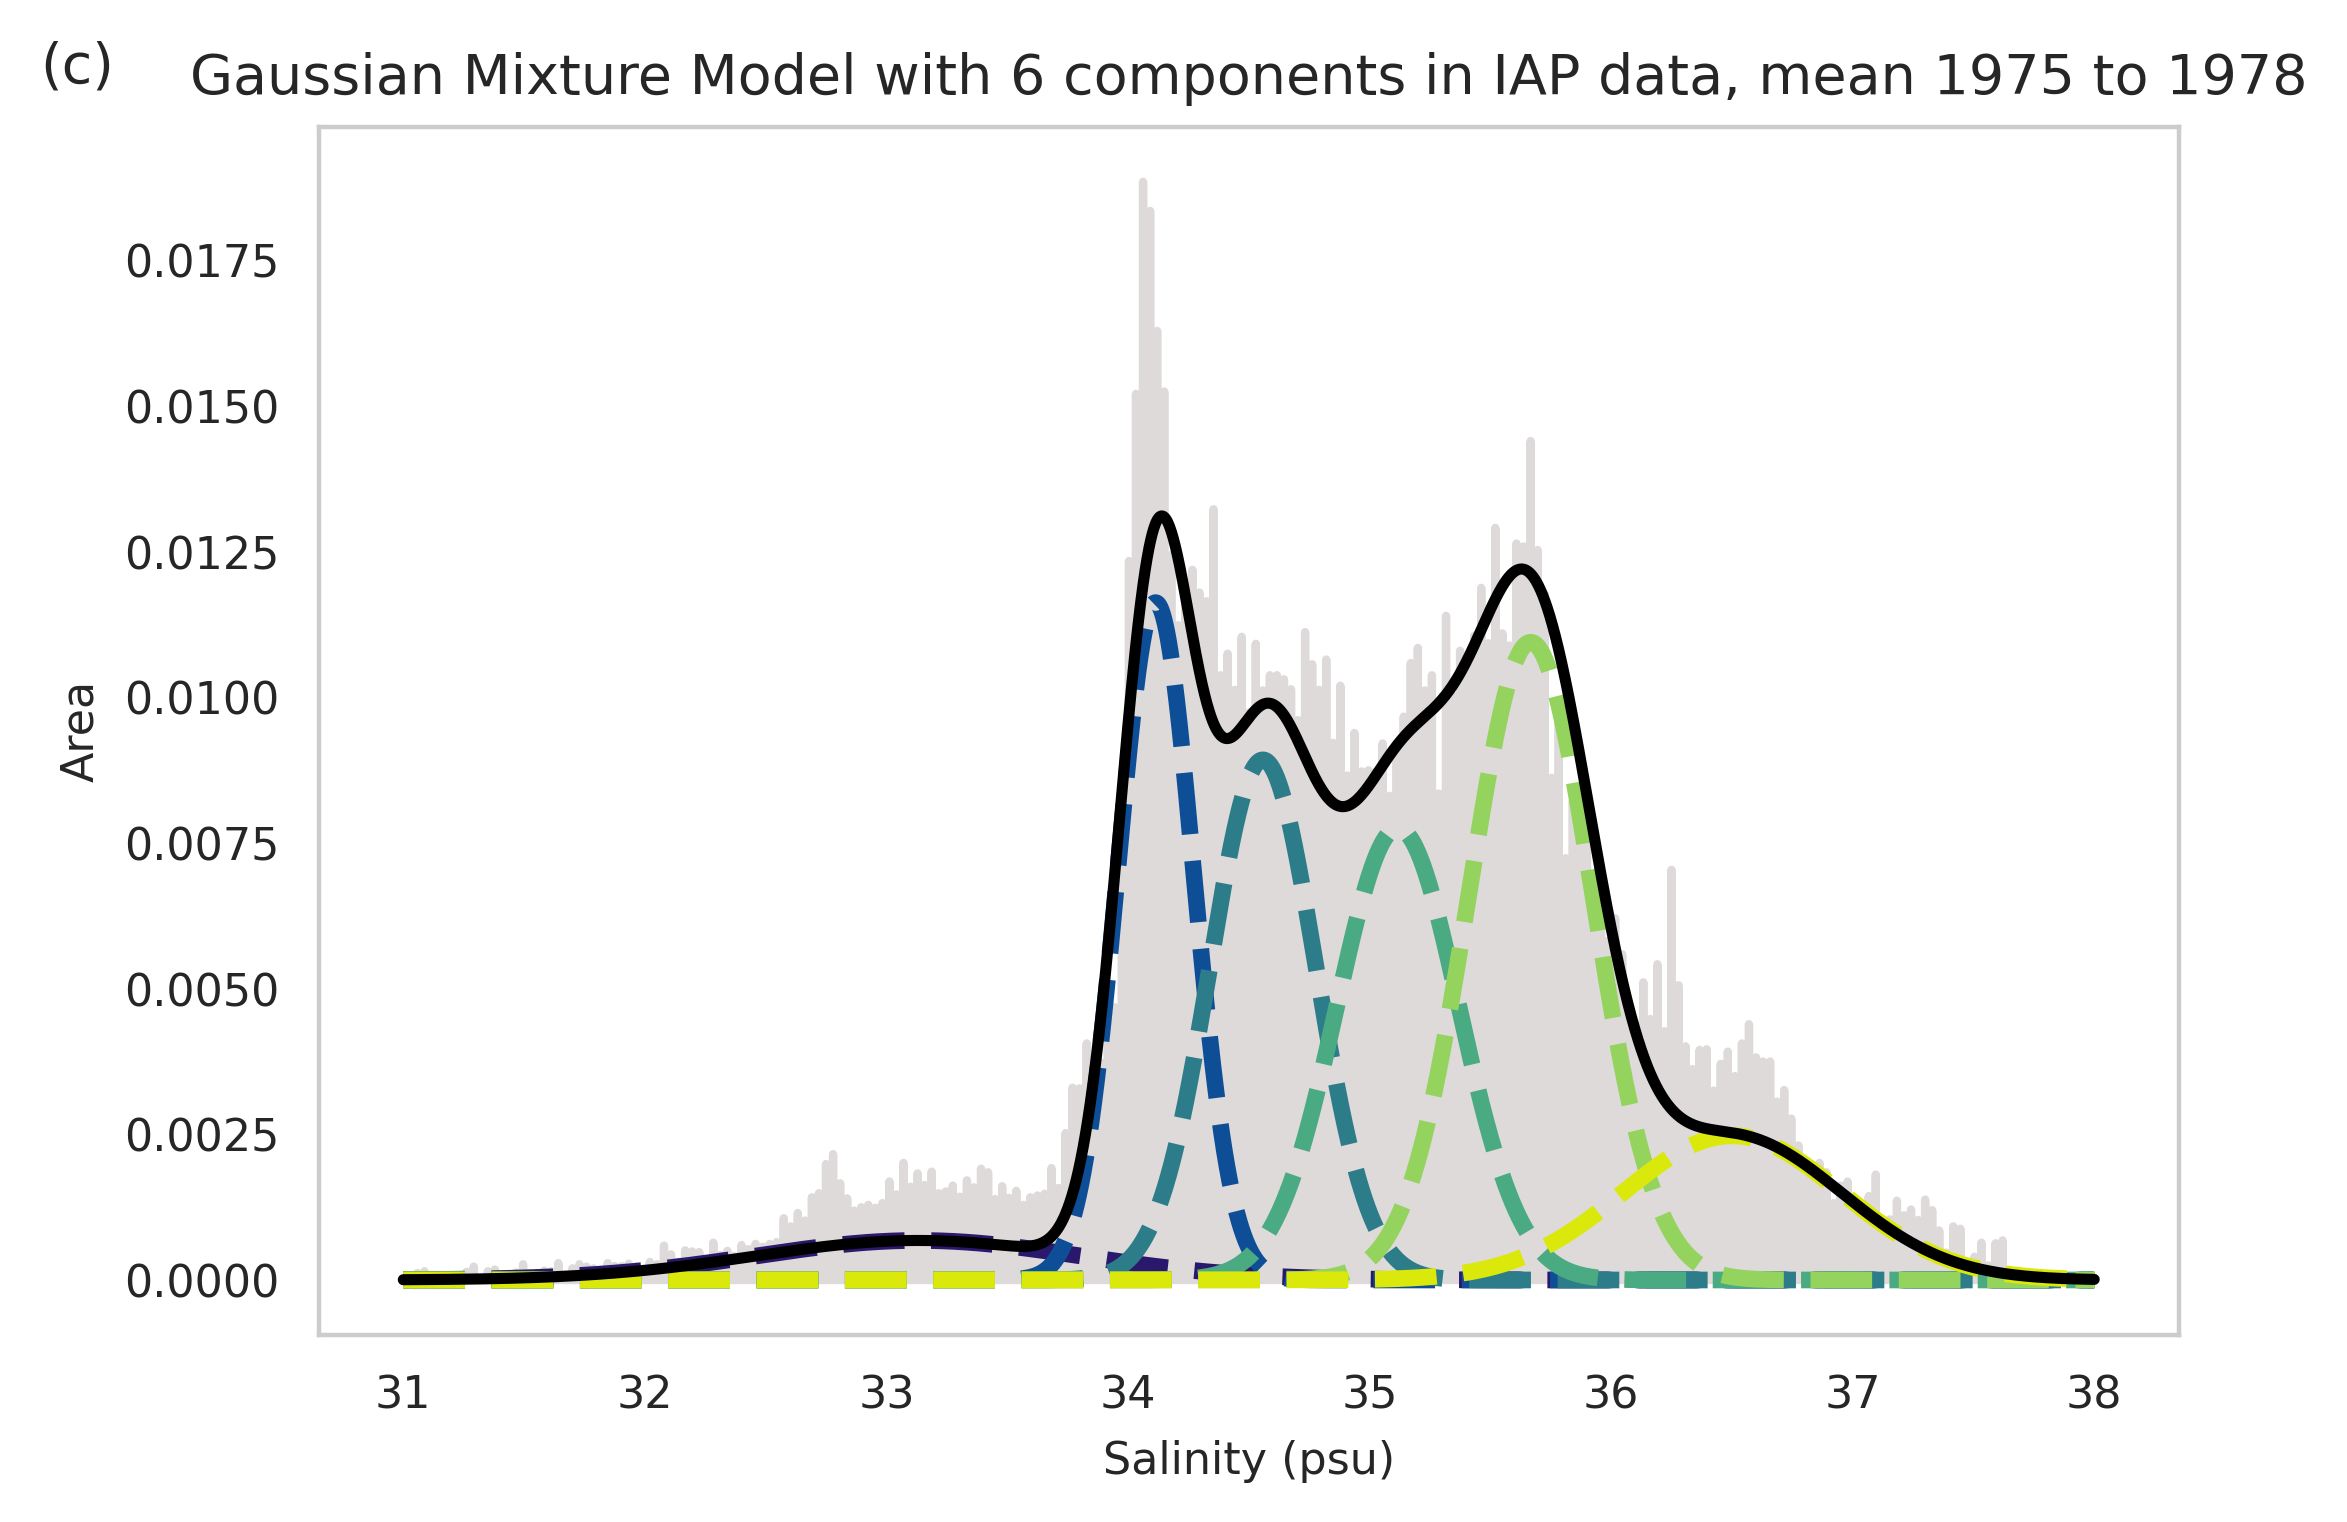

In [7]:
n=6
%load_ext autoreload 
%autoreload 2

import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

from clustering_tools import *
mean_con,sigma_con,weights_con,gm=GMM_timedep((regrid_iap[3:8].mean('time')).where(regrid_iap.latitude<65),n,'IAP data, mean 1975 to 1978',matching_paper=1,subplot_label='(c)') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


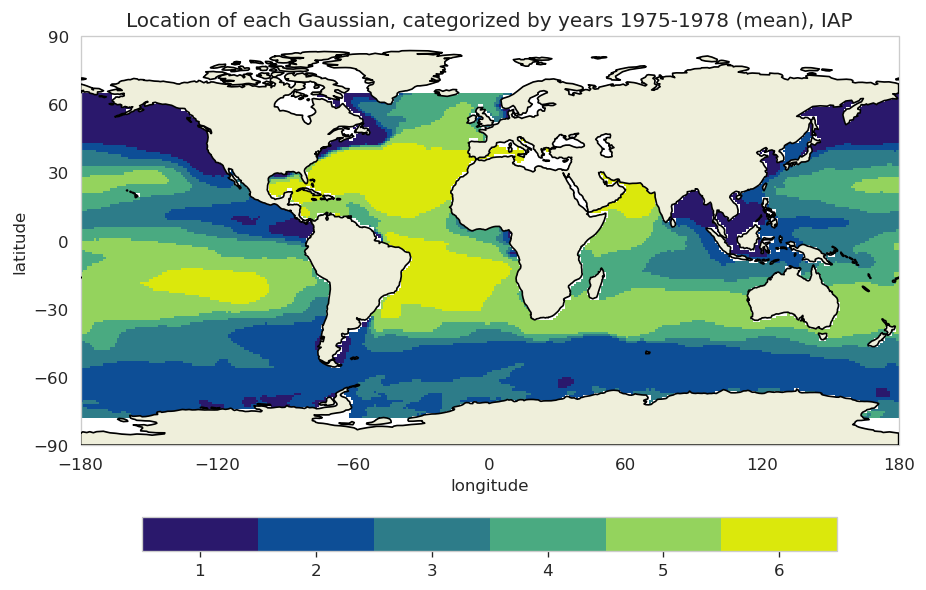

In [8]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2
y,a2=clusters(gm,regrid_iap[3:8].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), IAP',n,matching_paper=1,subplot_label='')

## Now do hypothesis/assumption checking

### 1. Let's do a quick check on an assumption that this paper makes - that the response of the observables (temperature and salinity in each GMM region) to wind stress, heat flux perturbation, and freshwater flux perturbation, makes up the total response. This is making fig 5 in the paper

In [9]:
#Load in all FAFMIP functions categorized by locations of the mixtures from IAP data above

from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(regrid_iap,area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(regrid_iap,area,a2,n)
    
from fafmip_gridding_tools import regridded_fafmip_temp_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_all,temp_had_all,temp_access_all, temp_access_con, temp_mit_con, temp_had_con=regridded_fafmip_temp_all_control(regrid_iap,area,a2,n) 
    
from fafmip_gridding_tools import regridded_fafmip_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_all,salt_mom_all, salt_had_all,salt_access_all, salt_access_con, salt_had_con, salt_mit_con=regridded_fafmip_all_control(regrid_iap,area,a2,n) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#Define changes in the FAFMIP stuff (comparing to control)

#CHANGE IN MITgcm
#TEMP
change_temp_mit_stress=temp_mit_stress[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_water=temp_mit_water[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_heat=temp_mit_heat[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_all=temp_mit_all[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)

#SALT
change_salt_mit_stress=salt_mit_stress[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_water=salt_mit_water[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_heat=salt_mit_heat[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_all=salt_mit_all[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)

#CHANGE IN ACCESS
#TEMP
change_temp_access_stress=temp_access_stress[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_water=temp_access_water[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_heat=temp_access_heat[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_all=temp_access_all[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)

#SALT 
change_salt_access_stress=salt_access_stress[60:67,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_water=salt_access_water[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_heat=salt_access_heat[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_all=salt_access_all[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)


#CHANGE IN HAD
#TEMP
change_temp_had_stress=temp_had_stress[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_water=temp_had_water[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_heat=temp_had_heat[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_all=temp_had_all[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)

#SALT
change_salt_had_stress=salt_had_stress[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_water=salt_had_water[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_heat=salt_had_heat[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_all=salt_had_all[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)

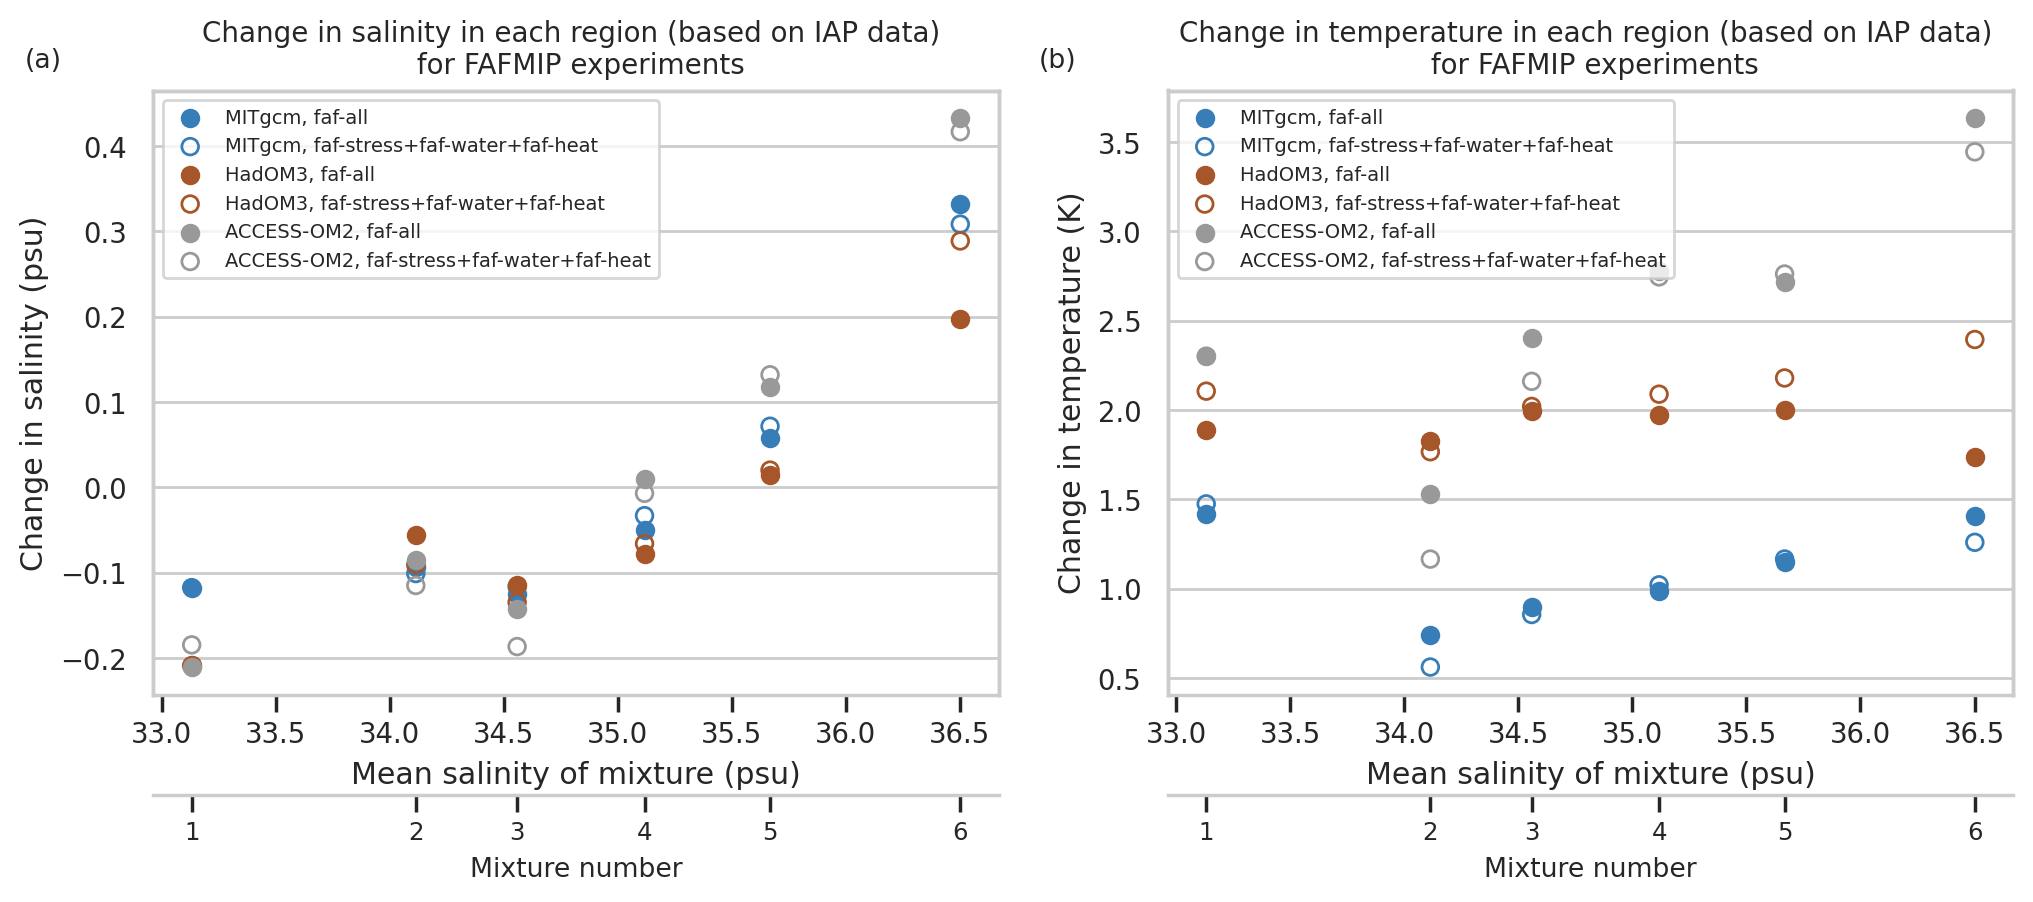

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))


sns.set(font_scale=0.8)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background



#LEFT PLOT
ax1_twin = ax1.twiny()
ax1_twin.xaxis.grid()
ax1.xaxis.grid()
ax1.scatter(mean_con,change_salt_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax1.scatter(mean_con,change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_had_all,color="#a65628",label="HadOM3, faf-all")
ax1.scatter(mean_con,change_salt_had_heat+change_salt_had_water+change_salt_had_stress,color="none",edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax1.scatter(mean_con,change_salt_access_heat+change_salt_access_water+change_salt_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax1.set_title('Change in salinity in each region (based on IAP data) \n for FAFMIP experiments',fontsize=10)
ax1.set_xlabel('Mean salinity of mixture (psu)')
ax1.set_ylabel('Change in salinity (psu)')
ax1.legend(fontsize=7)
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax1_twin.set_xticks(newpos)


ax1_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.spines['bottom'].set_position(('outward', 36))
ax1_twin.set_xlabel('Mixture number')
ax1_twin.set_xlim(ax1.get_xlim())
ax1_twin.set_xticks(newpos)
ax1_twin.set_xticklabels(newlabel)

#RIGHT PLOT
ax2.xaxis.grid()
ax2.scatter(mean_con,change_temp_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax2.scatter(mean_con,change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_had_all,color="#a65628",label="HadOM3, faf-all")
ax2.scatter(mean_con,change_temp_had_heat+change_temp_had_water+change_temp_had_stress,color='none', edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax2.scatter(mean_con,change_temp_access_heat+change_temp_access_water+change_temp_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax2.set_title('Change in temperature in each region (based on IAP data) \n for FAFMIP experiments',fontsize=10)
ax2.set_xlabel('Mean salinity of mixture (psu)')
ax2.set_ylabel('Change in temperature (K)')
ax2.legend(fontsize=7)
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

ax2_twin = ax2.twiny()
ax2_twin.xaxis.grid()
ax2_twin.set_xticks(newpos)
ax2_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.spines['bottom'].set_position(('outward', 36))
ax2_twin.set_xlabel('Mixture number')
ax2_twin.set_xlim(ax2.get_xlim())
ax2_twin.set_xticks(newpos)
ax2_twin.set_xticklabels(newlabel)
mpl.pyplot.savefig('linearity_assumption_dual_iap_5year.png', dpi=500,bbox_inches='tight')

In [12]:
#Compare norm of the change in sum of water+heat+stress experiments compared to faf-all (salt)
print(np.linalg.norm(change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress)/np.linalg.norm(change_salt_mit_all))
print(np.linalg.norm(change_salt_access_heat+change_salt_access_water+change_salt_access_stress)/np.linalg.norm(change_salt_access_all))
print(np.linalg.norm(change_salt_had_heat+change_salt_had_water+change_salt_had_stress)/np.linalg.norm(change_salt_had_all))

0.9499313565072861
1.000001090704705
1.228497984520455


In [13]:
#Compare norm of the change in sum of water+heat+stress experiments compared to faf-all (temp)
print(np.linalg.norm(change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress)/np.linalg.norm(change_temp_mit_all))
print(np.linalg.norm(change_temp_access_heat+change_temp_access_water+change_temp_access_stress)/np.linalg.norm(change_temp_access_all))
print(np.linalg.norm(change_temp_had_heat+change_temp_had_water+change_temp_had_stress)/np.linalg.norm(change_temp_had_all))

0.9721676147730647
0.9588506907854465
1.1033091681396583


### 2. Now let's look at the change in each region due to each kind of forcing. This is making Figure S2 in the paper plus an equivalent to S4 for IAP data (not in paper or supplement)

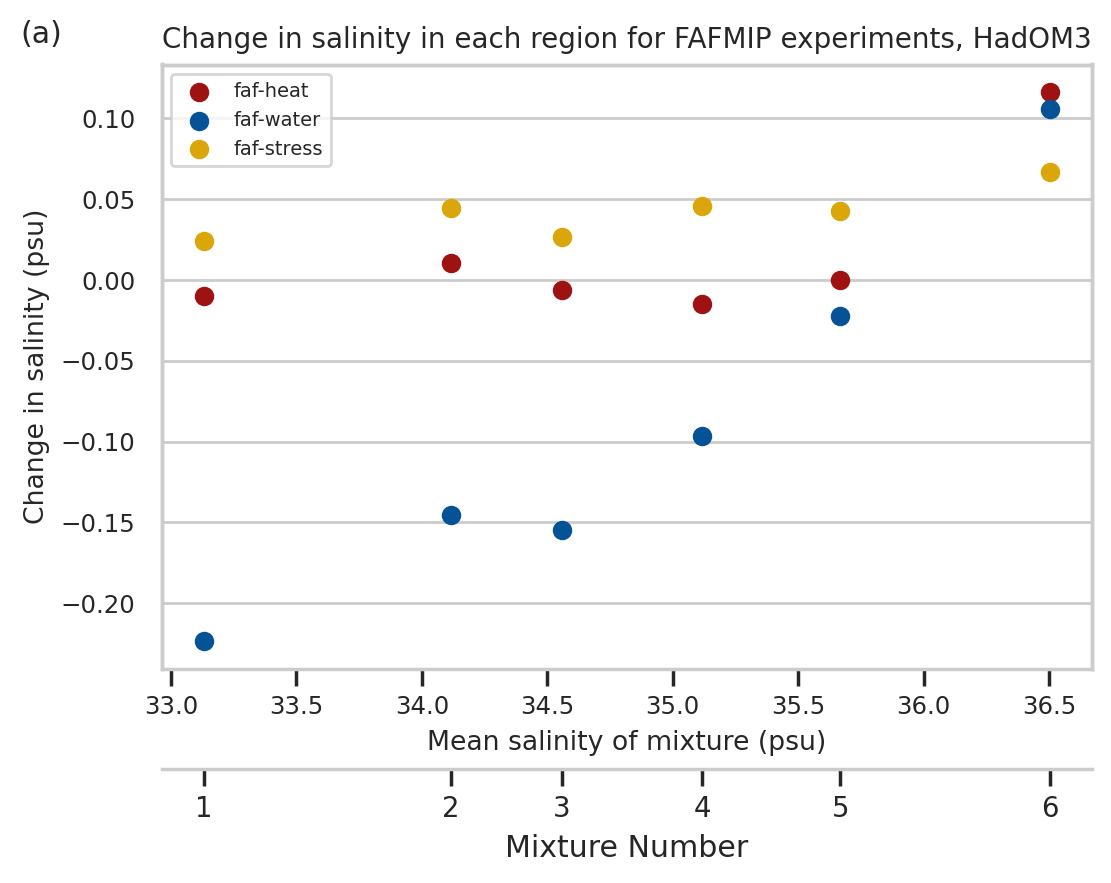

In [14]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in salinity in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_hadom3_iap_clusters_new_5year.png', dpi=500,bbox_inches='tight')

Text(-0.13, 1.05, '(b)')

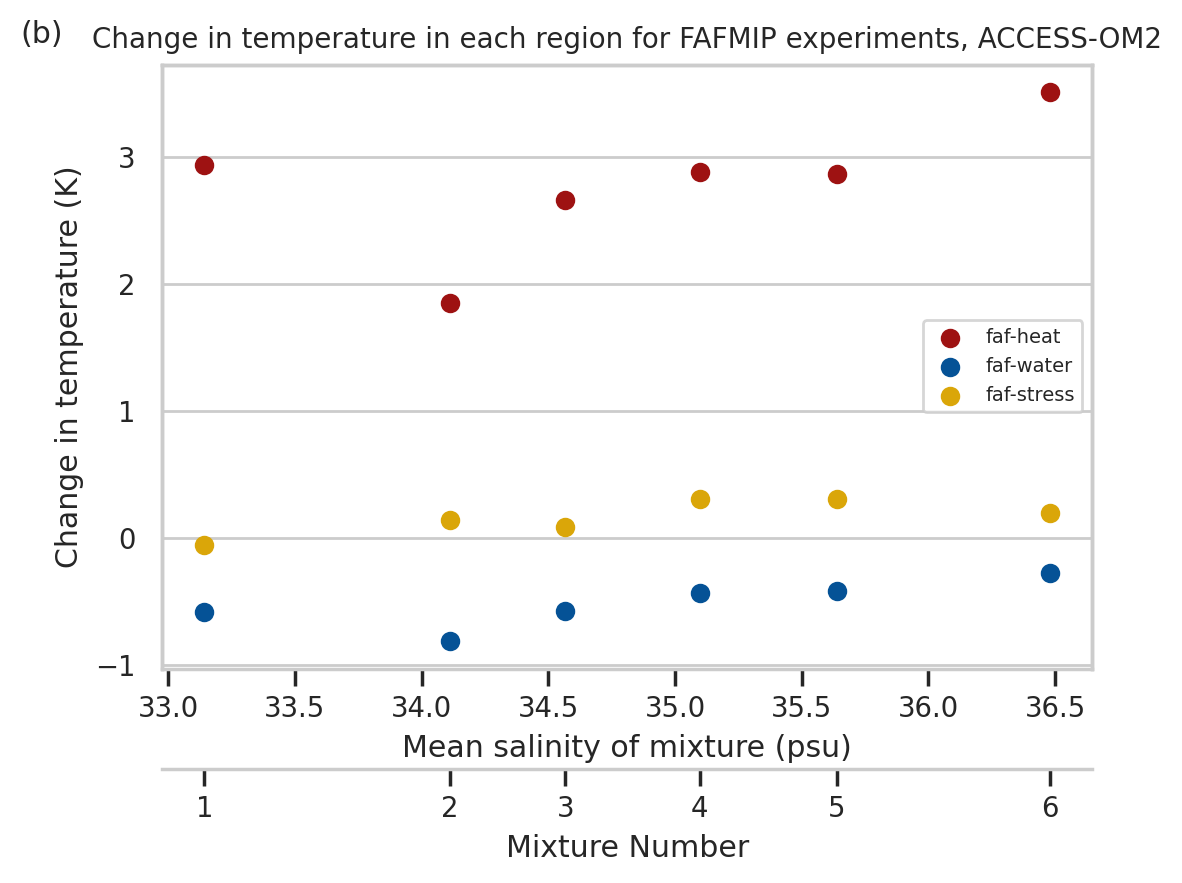

In [15]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_access_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, ACCESS-OM2', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

Text(-0.13, 1.05, '(c)')

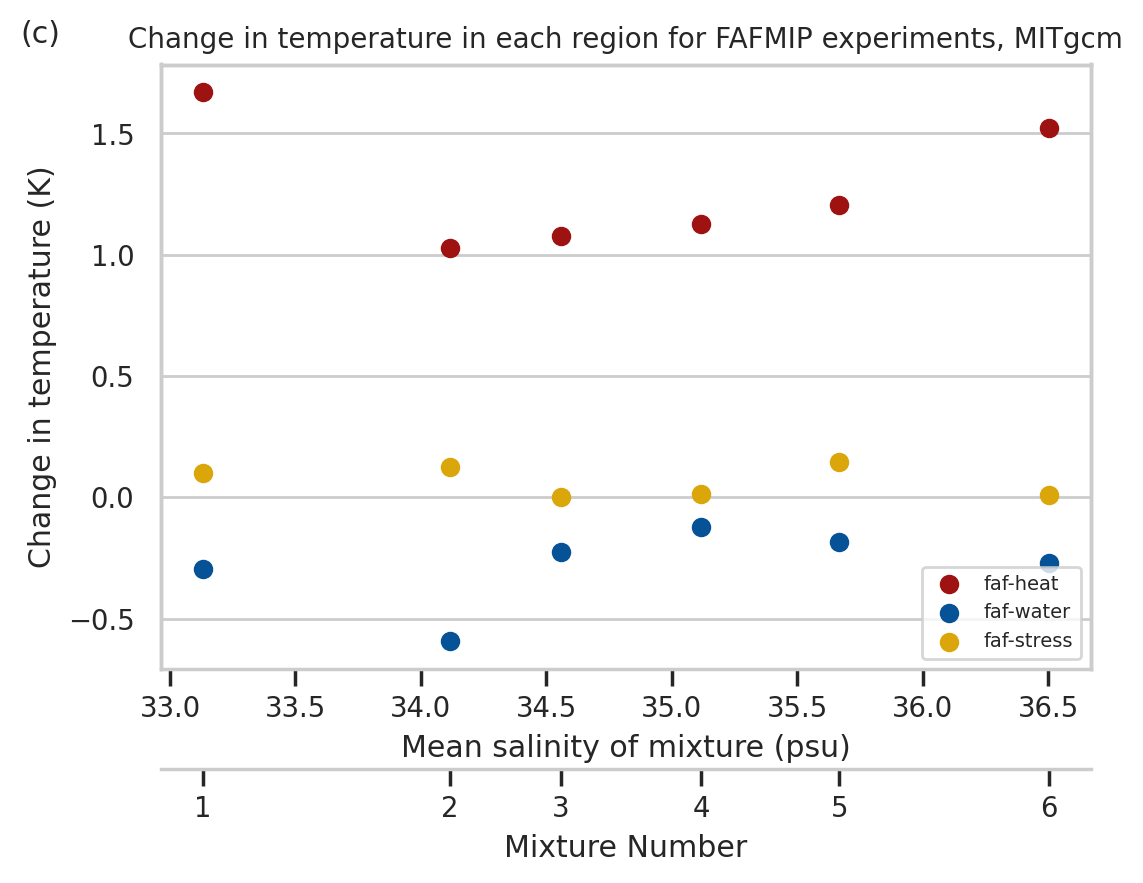

In [15]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_mit_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, MITgcm', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
#mpl.pyplot.savefig('individual_forcings_mitgcm_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

Text(-0.13, 1.05, '(a)')

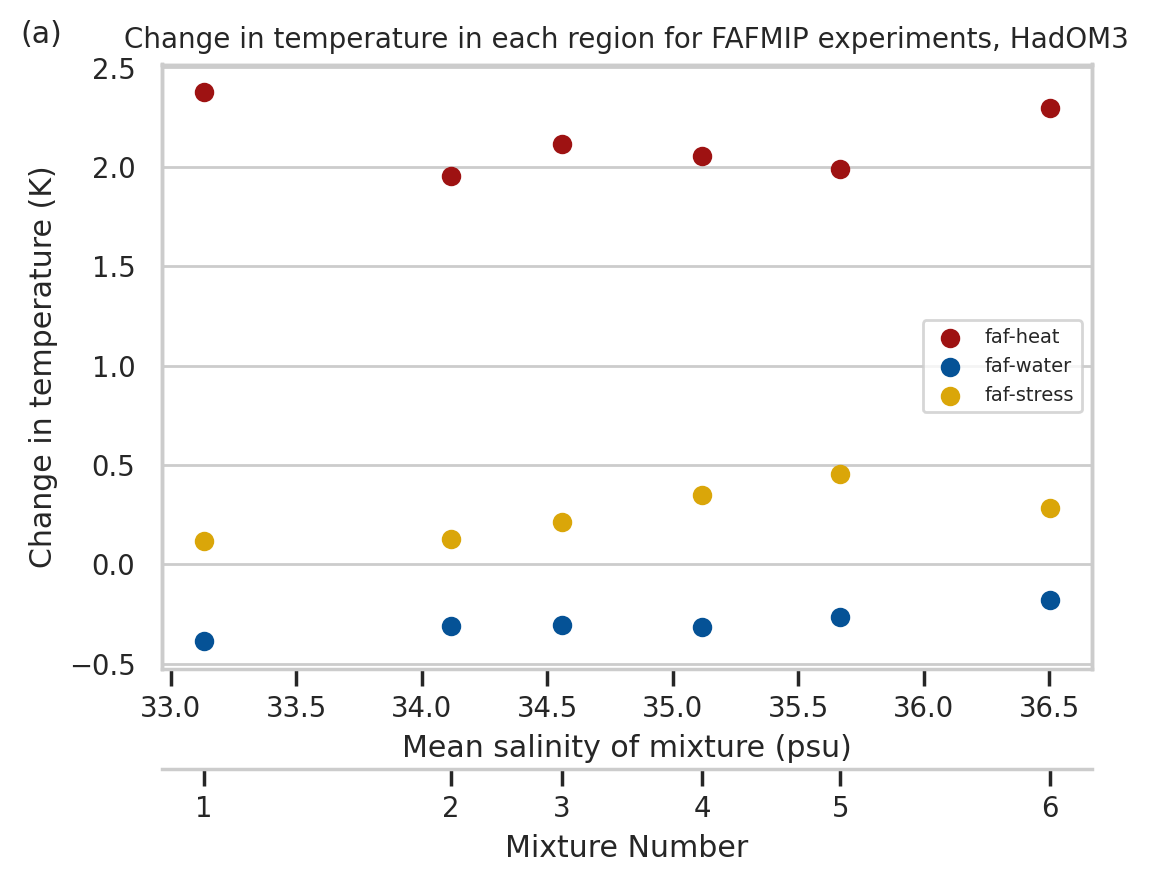

In [16]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
#mpl.pyplot.savefig('individual_forcings_had_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

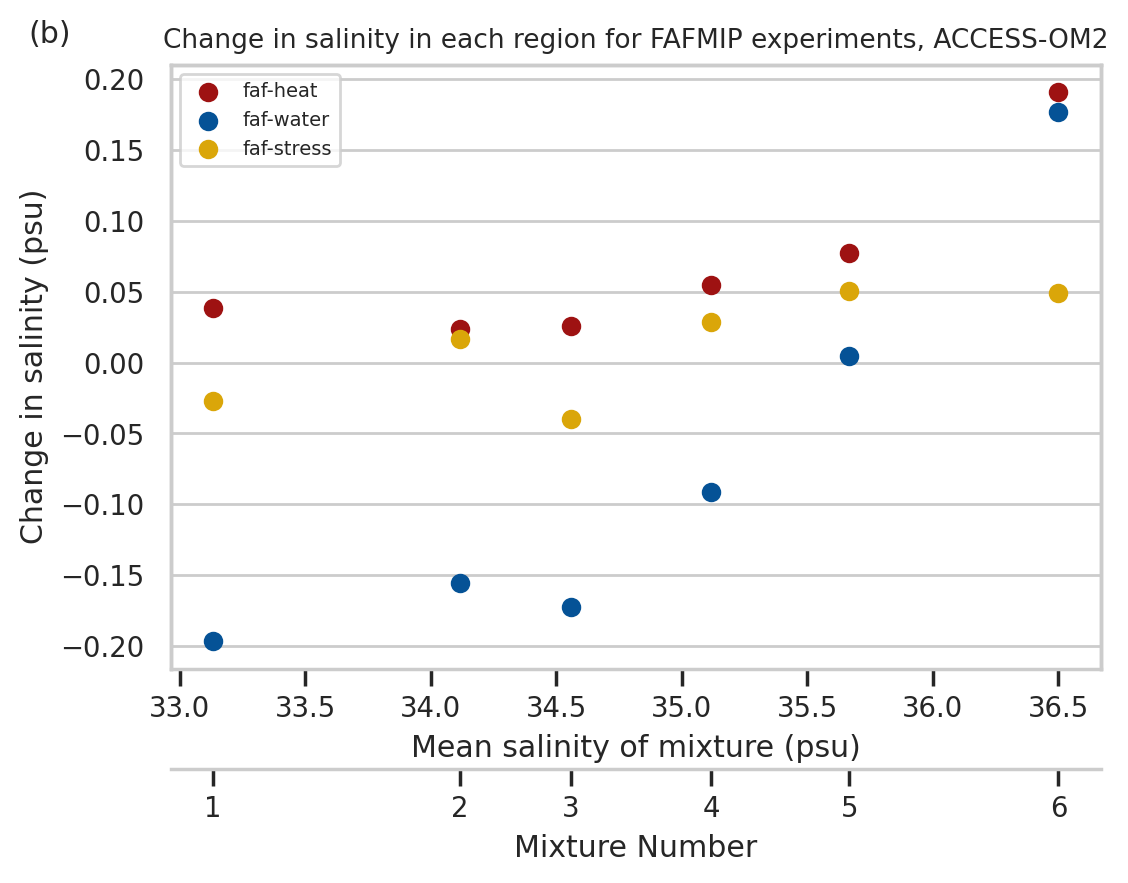

In [19]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_access_stress,color="#DAA609",label="faf-stress")


# Set second x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()

# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())



ax.set_title('Change in salinity in each region for FAFMIP experiments, ACCESS-OM2', fontsize=9.5)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_iap_clusters_new_5year.png', dpi=500,bbox_inches='tight')

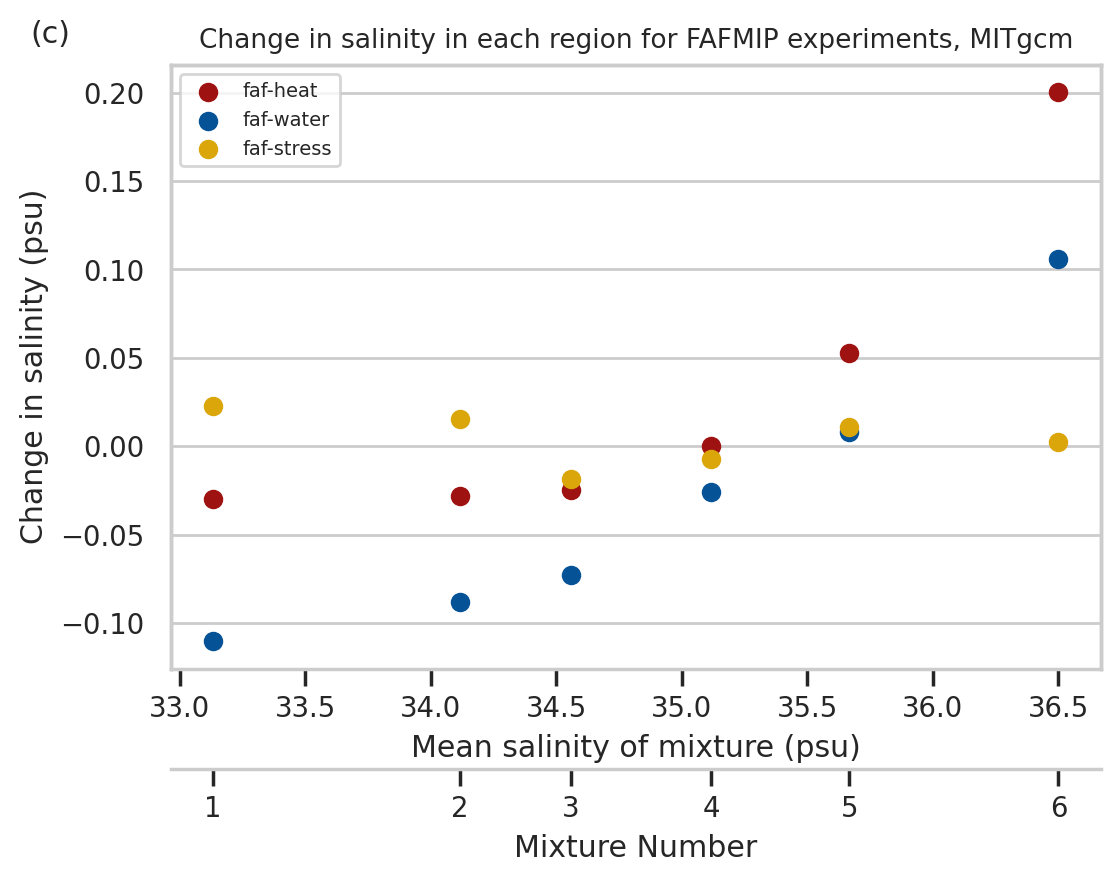

In [18]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_mit_stress,color="#DAA609",label="faf-stress")


# Set second x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()

# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())



ax.set_title('Change in salinity in each region for FAFMIP experiments, MITgcm', fontsize=9.5)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_mitgcm_iap_clusters_new_5year.png', dpi=500,bbox_inches='tight')

### 3. Plot the responses from the FAFMIP models. Not used in the paper figures but nice to see the response functions

In [20]:
from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(regrid_iap[3:48,:,:],area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(regrid_iap[3:48,:,:],area,a2,n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 1.0, 'Change in salinity in each region, MITgcm ocean-only FAFMIP, clusters based on IAP')

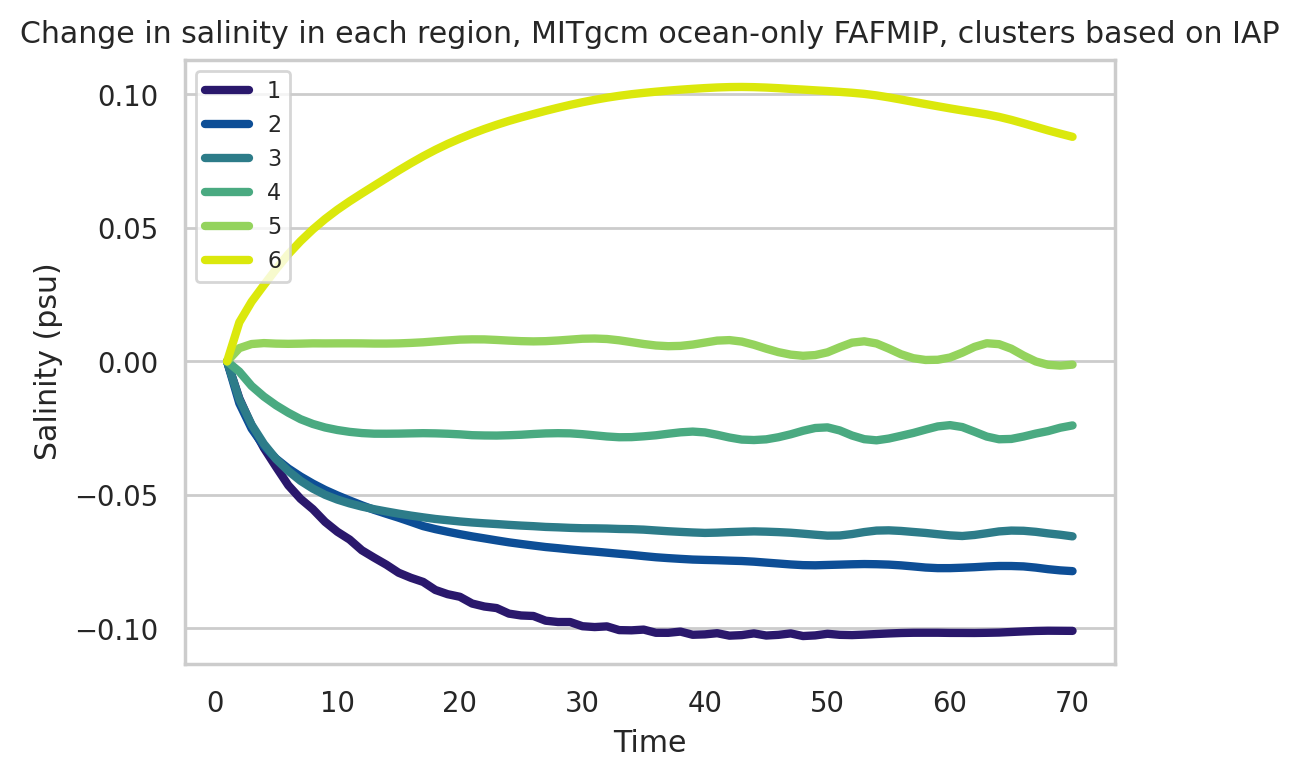

In [23]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_mit_water-np.mean(salt_mit_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, MITgcm ocean-only FAFMIP, clusters based on IAP')

Text(0.5, 1.0, 'Change in salinity in each region, ACCESS-OM2 ocean-only FAFMIP, clusters based on IAP')

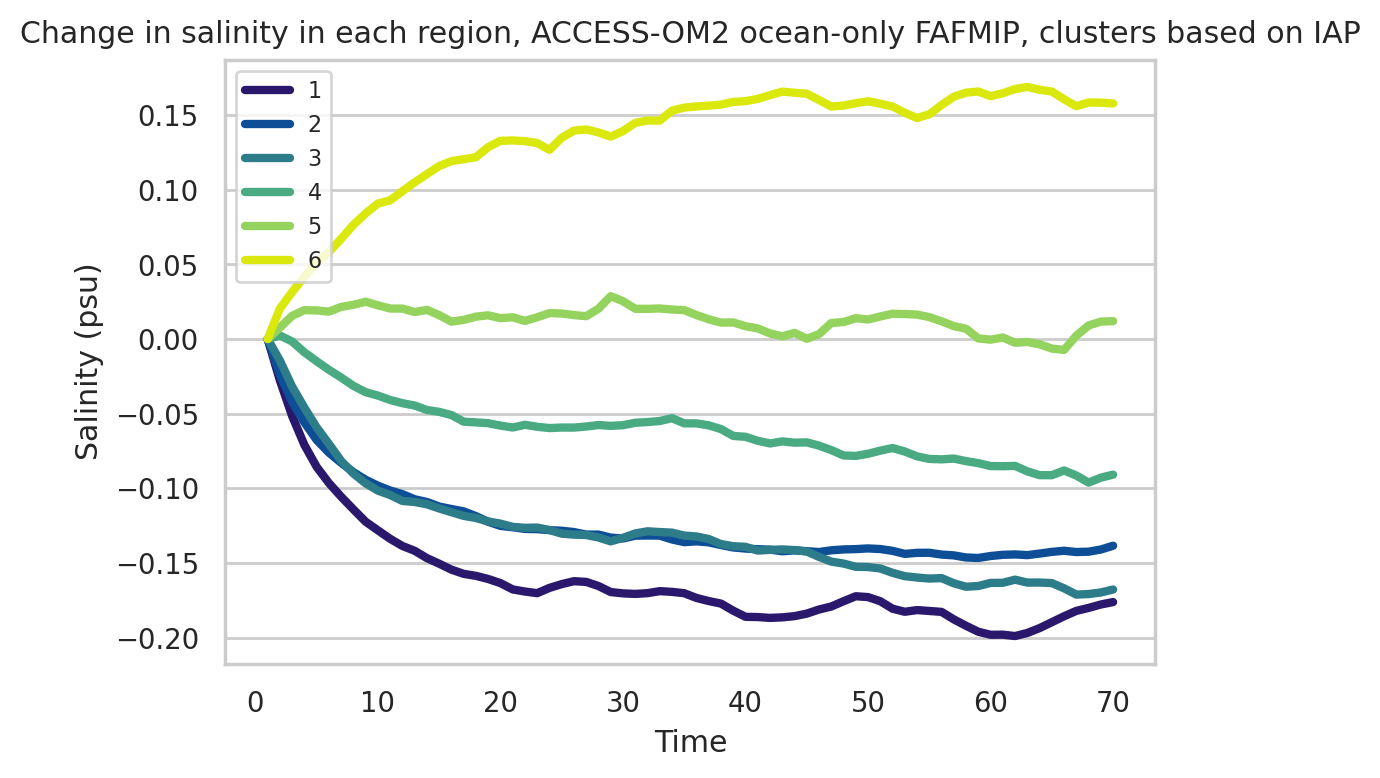

In [24]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_access_water-np.mean(salt_access_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, ACCESS-OM2 ocean-only FAFMIP, clusters based on IAP')

Text(0.5, 1.0, 'Change in salinity in each region, HadOM3 ocean-only FAFMIP, clusters based on IAP')

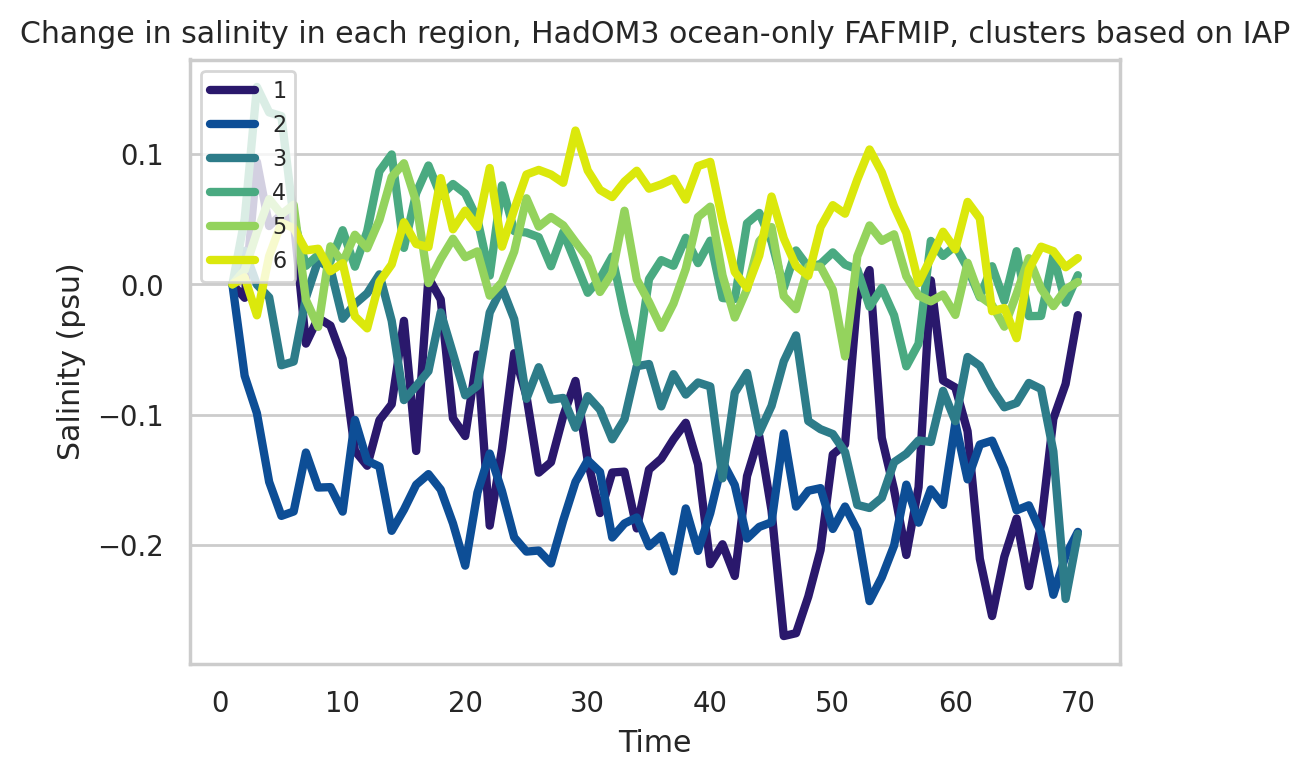

In [25]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_had_water-np.mean(salt_had_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, HadOM3 ocean-only FAFMIP, clusters based on IAP')